# Multilayer perceptrons from scratch

In the previous chapters we showed how you could implement multiclass logistic regression 
(also called *softmax regression*)
for classifiying images of handwritten digits into the 10 possible categories
([from scratch](../chapter02_supervised-learning/softmax-regression-scratch.ipynb) and [with gluon](../chapter02_supervised-learning/softmax-regression-gluon.ipynb)). 
This is where things start to get fun.
We understand how to wrangle data, 
coerce our outputs into a valid probability distribution,
how to apply an appropriate loss function,
and how to optimize over our parameters.
Now that we've covered these preliminaries, 
we can extend our toolbox to include deep neural networks.

Recall that before, we mapped our inputs directly onto our outputs through a single linear transformation.
$$\hat{y} = \mbox{softmax}(W \boldsymbol{x} + b)$$

Graphically, we could depict the model like this, where the orange nodes represent inputs and the teal nodes on the top represent the output:
![](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/img/simple-softmax-net.png?raw=true)

If our labels really were related to our input data by an approximately linear function,
then this approach might be adequate.
*But linearity is a strong assumption*.
Linearity means that given an output of interest,
for each input,
increasing the value of the input should either drive the value of the output up
or drive it down,
irrespective of the value of the other inputs.

Imagine the case of classifying cats and dogs based on black and white images.
That's like saying that for each pixel, 
increasing its value either increases the probability that it depicts a dog or decreases it.
That's not reasonable. After all, the world contains both black dogs and black cats, and both white dogs and white cats. 

Teasing out what is depicted in an image generally requires allowing more complex relationships between
our inputs and outputs, considering the possibility that our pattern might be characterized by interactions among the many features. 
In these cases, linear models will have low accuracy. 
We can model a more general class of functions by incorporating one or more *hidden layers*.
The easiest way to do this is to stack a bunch of layers of neurons on top of each other.
Each layer feeds into the layer above it, until we generate an output.
This architecture is commonly called a "multilayer perceptron".
With an MLP, we're going to stack a bunch of layers on top of each other.

$$ h_1 = \phi(W_1\boldsymbol{x} + b_1) $$
$$ h_2 = \phi(W_2\boldsymbol{h_1} + b_2) $$
$$...$$
$$ h_n = \phi(W_n\boldsymbol{h_{n-1}} + b_n) $$

Note that each layer requires its own set of parameters.
For each hidden layer, we calculate its value by first applying a linear function 
to the activations of the layer below, and then applying an element-wise
nonlinear activation function. 
Here, we've denoted the activation function for the hidden layers as $\phi$.
Finally, given the topmost hidden layer, we'll generate an output.
Because we're still focusing on multiclass classification, we'll stick with the softmax activation in the output layer.

$$ \hat{y} = \mbox{softmax}(W_y \boldsymbol{h}_n + b_y)$$

Graphically, a multilayer perceptron could be depicted like this:

![](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/img/multilayer-perceptron.png?raw=true)

Multilayer perceptrons can account for complex interactions in the inputs because 
the hidden neurons depend on the values of each of the inputs. 
It's easy to design a hidden node that that does arbitrary computation,
such as, for instance, logical operations on its inputs.
And it's even widely known that multilayer perceptrons are universal approximators. 
That means that even for a single-hidden-layer neural network,
with enough nodes, and the right set of weights, it could model any function at all!
Actually learning that function is the hard part. 
And it turns out that we can approximate functions much more compactly if we use deeper (vs wider) neural networks.
We'll get more into the math in a subsequent chapter, but for now let's actually build an MLP.
In this example, we'll implement a multilayer perceptron with two hidden layers and one output layer.

## Imports

In [1]:
from __future__ import print_function
import mxnet as mx
import numpy as np
from mxnet import nd, autograd, gluon

## Set contexts

In [2]:
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()
data_ctx = ctx
model_ctx = ctx

## Load MNIST data

Let's go ahead and grab our data.

In [3]:
num_inputs = 784
num_outputs = 10
batch_size = 64
num_examples = 60000
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
train_data = gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False)

## Allocate parameters



In [4]:
#######################
#  Set some constants so it's easy to modify the network later
####################### 
num_hidden = 256
weight_scale = .01

#######################
#  Allocate parameters for the first hidden layer
####################### 
W1 = nd.random_normal(shape=(num_inputs, num_hidden), scale=weight_scale, ctx=model_ctx)
b1 = nd.random_normal(shape=num_hidden, scale=weight_scale, ctx=model_ctx)

#######################
#  Allocate parameters for the second hidden layer
####################### 
W2 = nd.random_normal(shape=(num_hidden, num_hidden), scale=weight_scale, ctx=model_ctx)
b2 = nd.random_normal(shape=num_hidden, scale=weight_scale, ctx=model_ctx)

#######################
#  Allocate parameters for the output layer
####################### 
W3 = nd.random_normal(shape=(num_hidden, num_outputs), scale=weight_scale, ctx=model_ctx)
b3 = nd.random_normal(shape=num_outputs, scale=weight_scale, ctx=model_ctx)

params = [W1, b1, W2, b2, W3, b3]

Again, let's allocate space for each parameter's gradients.

In [5]:
for param in params:
    param.attach_grad()

## Activation functions

If we compose a multi-layer network but use only linear operations, then our entire network will still be a linear function. That's because $\hat{y} = X \cdot W_1 \cdot W_2 \cdot W_2 = X \cdot W_4 $ for $W_4 = W_1 \cdot W_2 \cdot W3$. To give our model the capacity to capture nonlinear functions, we'll need to interleave our linear operations with activation functions. In this case, we'll use the rectified linear unit (ReLU):

In [6]:
def relu(X):
    return nd.maximum(X, nd.zeros_like(X))

## Softmax output

As with multiclass logistic regression, we'll want the outputs to constitute a valid probability distribution. We'll use the same softmax activation function on our output to make sure that our outputs sum to one and are non-negative.

In [7]:
def softmax(y_linear):
    exp = nd.exp(y_linear-nd.max(y_linear))
    partition = nd.nansum(exp, axis=0, exclude=True).reshape((-1, 1))
    return exp / partition

## The *softmax* cross-entropy loss function

In the previous example, we calculated our model's output and then ran this output through the cross-entropy loss function: 

In [8]:
def cross_entropy(yhat, y):
    return - nd.nansum(y * nd.log(yhat), axis=0, exclude=True)

Mathematically, that's a perfectly reasonable thing to do. However, computationally, things can get hairy. We'll revisit the issue at length in a chapter more dedicated to implementation and less interested in statistical modeling. But we're going to make a change here so we want to give you the gist of why.

Recall that the softmax function calculates $\hat y_j = \frac{e^{z_j}}{\sum_{i=1}^{n} e^{z_i}}$, where $\hat y_j$ is the j-th element of the input ``yhat`` variable in function ``cross_entropy`` and $z_j$ is the j-th element of the input ``y_linear`` variable in function ``softmax``

If some of the $z_i$ are very large (i.e. very positive), $e^{z_i}$ might be larger than the largest number we can have for certain types of ``float`` (i.e. overflow). This would make the denominator (and/or numerator) ``inf`` and we get zero, or ``inf``, or ``nan`` for $\hat y_j$. In any case, we won't get a well-defined return value for ``cross_entropy``. This is the reason we subtract $\text{max}(z_i)$ from all $z_i$ first in ``softmax`` function. You can verify that this shifting in $z_i$ will not change the return value of ``softmax``.

After the above subtraction/ normalization step, it is possible that $z_j$ is very negative. Thus, $e^{z_j}$ will be very close to zero and might be rounded to zero due to finite precision (i.e underflow), which makes $\hat y_j$ zero and we get ``-inf`` for $\text{log}(\hat y_j)$. A few steps down the road in backpropagation, we starts to get horrific not-a-number (``nan``) results printed to screen.

Our salvation is that even though we're computing these exponential functions, we ultimately plan to take their log in the cross-entropy functions. It turns out that by combining these two operators ``softmax`` and ``cross_entropy`` together, we can elude the numerical stability issues that might otherwise plague us during backpropagation. As shown in the equation below, we avoided calculating $e^{z_j}$ but directly used $z_j$ due to $log(exp(\cdot))$.
$$\text{log}{(\hat y_j)} = \text{log}\left( \frac{e^{z_j}}{\sum_{i=1}^{n} e^{z_i}}\right) = \text{log}{(e^{z_j})}-\text{log}{\left( \sum_{i=1}^{n} e^{z_i} \right)} = z_j -\text{log}{\left( \sum_{i=1}^{n} e^{z_i} \right)}$$

We'll want to keep the conventional softmax function handy in case we ever want to evaluate the probabilities output by our model. But instead of passing softmax probabilities into our new loss function, we'll just pass our ``yhat_linear`` and compute the softmax and its log all at once inside the softmax_cross_entropy loss function, which does smart things like the log-sum-exp trick ([see on Wikipedia](https://en.wikipedia.org/wiki/LogSumExp)).


In [9]:
def softmax_cross_entropy(yhat_linear, y):
    return - nd.nansum(y * nd.log_softmax(yhat_linear), axis=0, exclude=True)

## Define the model

Now we're ready to define our model

In [10]:
def net(X):
    #######################
    #  Compute the first hidden layer
    #######################
    h1_linear = nd.dot(X, W1) + b1
    h1 = relu(h1_linear)

    #######################
    #  Compute the second hidden layer
    #######################
    h2_linear = nd.dot(h1, W2) + b2
    h2 = relu(h2_linear)

    #######################
    #  Compute the output layer.
    #  We will omit the softmax function here
    #  because it will be applied
    #  in the softmax_cross_entropy loss
    #######################
    yhat_linear = nd.dot(h2, W3) + b3
    return yhat_linear

## Optimizer

In [11]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

## Evaluation metric

In [12]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

## Execute the training loop

In [13]:
epochs = 10
learning_rate = .001
smoothing_constant = .01

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()


    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

Epoch 0. Loss: 1.2515217730840047, Train_acc 0.87511665, Test_acc 0.8787
Epoch 1. Loss: 0.32968043766816457, Train_acc 0.9273833, Test_acc 0.9287
Epoch 2. Loss: 0.22200340533653895, Train_acc 0.9484, Test_acc 0.9453
Epoch 3. Loss: 0.16145598207712172, Train_acc 0.96215, Test_acc 0.96
Epoch 4. Loss: 0.1270556022286415, Train_acc 0.96815, Test_acc 0.9655
Epoch 5. Loss: 0.1035012032210827, Train_acc 0.97286665, Test_acc 0.9648
Epoch 6. Loss: 0.08724449458320936, Train_acc 0.9777667, Test_acc 0.9685
Epoch 7. Loss: 0.07477289570420981, Train_acc 0.97943336, Test_acc 0.9703
Epoch 8. Loss: 0.06435769413113594, Train_acc 0.9859333, Test_acc 0.9728
Epoch 9. Loss: 0.05622949782436093, Train_acc 0.98763335, Test_acc 0.9754


## Using the model for prediction
Let's pick a few random data points from the test set to visualize algonside our predictions. We already know quantitatively that the model is more accurate, but visualizing results is a good practice that can (1) help us to sanity check that our code is actually working and (2) provide intuition about what kinds of mistakes our model tends to make.

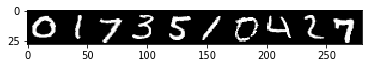

model predictions are: 
[0. 1. 7. 3. 5. 1. 0. 4. 2. 7.]
<NDArray 10 @gpu(0)>
true labels : 
[0. 1. 7. 3. 5. 1. 0. 4. 2. 7.]
<NDArray 10 @cpu(0)>


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# Define the function to do prediction
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

samples = 10

mnist_test = mx.gluon.data.vision.MNIST(train=False, transform=transform)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mnist_test, samples, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))
    
    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    print('true labels :', label)
    break

## Conclusion

Nice! With just two hidden layers containing 256 hidden nodes, respectively, we can achieve over 95% accuracy on this task. 

## Next
[Multilayer perceptrons with gluon](../chapter03_deep-neural-networks/mlp-gluon.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)